In [181]:
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint
import torch.optim as optim
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We'll create a fake ODE

$$\frac{dy}{dt} = Ky\sin(t/10)$$

where $K$ is an anti-symmetric matrix filled with random variables, and $y$ is a vector

In [389]:
def dydt(t, y, K):
    K_reshaped = K.unsqueeze(0).repeat(y.shape[0],1,1)
    y_reshaped = y.unsqueeze(-1)
    return torch.bmm(K_reshaped, y_reshaped).squeeze() * torch.sin(t/10)

# Part 1: Generate Fake Data

In [445]:
M = 3
realizations = 500

In [455]:
y0 = torch.rand((realizations,M)).to(device) + 1
K = torch.rand((M,M)).to(device)
K = K-K.T #antisymmetric
t_eval = torch.linspace(0, 50, 100).to(device)

In [456]:
true_sol = odeint(lambda t, y: dydt(t, y, K), y0, t_eval)

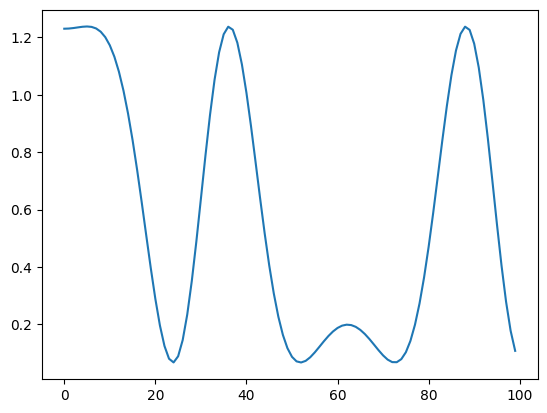

In [457]:
plt.plot(true_sol[:,0,1].cpu())

Question: How do we model the differential equation? One solution is to use a neural network.

In [458]:
class ODEFunc(nn.Module):
    def __init__(self, K_init):
        super(ODEFunc, self).__init__()
        self.register_parameter(name='K', param=torch.nn.Parameter(torch.clone(K_init)))

    def forward(self, t, y):
        K_reshaped = self.K.unsqueeze(0).repeat(y.shape[0],1,1)
        y_reshaped = y.unsqueeze(-1)
        return torch.bmm(K_reshaped, y_reshaped).squeeze() * torch.sin(t/10)

In [463]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(M, 50),
            nn.Tanh(),
            nn.Linear(50, M),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)* torch.sin(t/10)

In [464]:
ode_net = ODEFunc().to(device)
sol_init = odeint(ode_net, y0, t_eval, rtol=1e-4)

In [465]:
losses = []
optimizer = optim.RMSprop(ode_net.parameters(), lr=1e-3)
for i in range(1000):
    optimizer.zero_grad()
    sol = odeint(ode_net, y0, t_eval, rtol=1e-5)
    loss = torch.mean((sol - true_sol)**2)
    if i%10==0:
        print(loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

3.172156572341919
1.7356083393096924
1.7151516675949097
1.7015337944030762
1.68953537940979
1.6787049770355225
1.6689313650131226
1.6602591276168823
1.6530711650848389
1.6485437154769897


KeyboardInterrupt: 

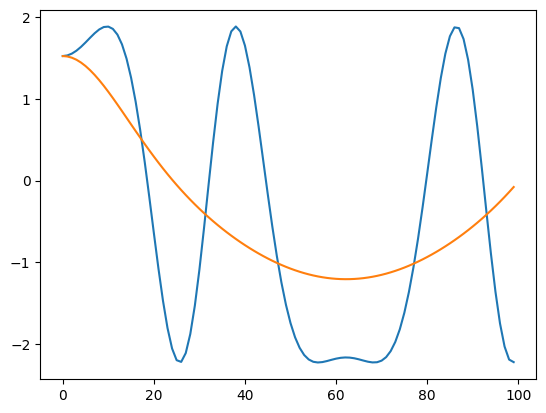

In [466]:
plt.plot(true_sol[:,0,2].cpu())
plt.plot(sol[:,0,2].cpu().detach())

In [ ]:
K

tensor([[ 0.0000,  0.1418,  0.2822, -0.6619, -0.4937],
        [-0.1418,  0.0000,  0.4418, -0.1873,  0.4499],
        [-0.2822, -0.4418,  0.0000, -0.2553, -0.4041],
        [ 0.6619,  0.1873,  0.2553,  0.0000,  0.2638],
        [ 0.4937, -0.4499,  0.4041, -0.2638,  0.0000]], device='cuda:0')